# Credit Risk - Practical Lesson 9

## Overview
In the past lessons we have already seen the concepts of credit event, survival probability and hazard rate.
Today we will concentrate more on the credit risk topic studying few more examples.

## Credit Ratings
A credit rating is a quantified assessment of the creditworthiness of a borrower either in general terms or with respect to a particular debt or financial obligation. A credit rating can be assigned to any entity that seeks to borrow money (e.g. an individual, corporation, state or provincial authority, or sovereign government).

Individual credit is scored from by credit bureaus (e.g. Experian and TransUnion). Credit assessment and evaluation for companies and governments instead is generally done by a credit rating agency (e.g. Standard & Poor’s (S&P), Moody’s, or Fitch). These rating agencies are paid by the entity that is seeking a credit rating for itself or for one of its debt issues.

### How Credit Rating Works
A loan is a essentially a promise and the credit rating determines the likelihood that the borrower will be able to pay back it within the loan agreement terms. 

A high credit rating indicates a high possibility of paying back the loan in its entirety without any issues; a poor credit rating suggests that the borrower has had trouble paying back loans in the past and might follow the same pattern in the future. 

Credit ratings apply to businesses and government, while credit scores apply only to individuals and it is reported as a number, generally ranging from 300 to 850.

A short-term credit rating reflects the likelihood of the borrower defaulting within the year. This type of credit rating has become the norm in recent years, whereas in the past, long-term credit ratings were more heavily considered. Long-term credit ratings predict the borrower's likelihood of defaulting at any given time in the extended future.

Credit rating agencies typically assign letter grades to indicate ratings. Standard & Poor’s, for instance, has a credit rating scale ranging from AAA (excellent) to C and D. A debt instrument with a rating below BB is considered to be a speculative grade or a junk bond, which means it is more likely to default on loans.

### Why Credit Ratings Are Important
While a borrowing entity will strive to have the highest possible credit rating since it has a major impact on interest rates charged by lenders, the rating agencies must take a balanced and objective view of the borrower’s financial situation and capacity to service/repay the debt.

A credit rating not only determines whether or not a borrower will be approved for a loan but also determines the interest rate at which the loan will need to be repaid. Since companies depend on loans for many start-up and other expenses, being denied a loan could spell disaster, and a high interest rate is much more difficult to pay back. Credit ratings also play a large role in a potential investor's determining whether or not to purchase bonds. A poor credit rating is a risky investment; it indicates a larger probability that the company will be unable to make its bond payments.

It is important for a borrower to remain diligent in maintaining a high credit rating. Credit ratings are never static; in fact, they change all the time based on the newest data, and one negative debt will bring down even the best score. Credit also takes time to build up. An entity with good credit but a short credit history is not seen as positively as another entity with the same quality of credit but a longer history. Debtors want to know a borrower can maintain good credit consistently over time.

Credit rating changes can have a significant impact on financial markets. A prime example is the adverse market reaction to the credit rating downgrade of the U.S. federal government by Standard & Poor’s on August 5, 2011. Global equity markets plunged for weeks following the downgrade.

### Historical Default Probabilities

## Bonds

## Default Probabilities and Bond Prices
We can estimate the probability of a company default directly form the prices of the bonds issued by it. The main assumption behind this idea is that a corporate bond is sold for less than a similar risk-free bond only if there is some possibility of default.

In order to do the estimate let's consider a zero-coupon bond paying one unit of value at maturity. The default probability of the bond is $\lambda$, the expected recovery rate is $R$ (the recovery rate for a bond is defined as a percentage of its face value equivalent to its market value after the default), and the risk-free discount rate is $r$. If the current bond value is $B$ we have:

$$B=\frac{(1-\lambda)+\lambda\cdot R}{(1+r)}$$

Solving the following equation for $p$ we get:

$$\lambda =\frac{1-(1+r)\cdot B}{1-R} = \frac{s}{1-R}$$

where the numerator can be interpreted as the spread $s$ between a risk-free bond and our bond at maturity. 





# VaR - Practical Lesson 9

## Overview
In this lesson we will talk about the *value at risk* variable.

## VaR
The VaR of a portfolio is a function of two parameters (time horizon and confidence level) and it is usually involved when it is important to know to a certain precentage of confidence how much will be the maximum loss
in the next $N $days. In other words it represents the loss level over $N$ days that has a probability of only $(100 - X)\%$ of being exceeded.

When $N$ days is the time horizon and $X\%$ is the confidence level, VaR is the losso corresponding to the $(100-X)\textrm{th}$ precentile of the distribution of the change in the value of the portfolio over the next $N$ days.
For example, with $N=1$ and $X=95$, VaR is the third percentile of the distribution of changes in the value of the portfolio over the next 5 days (e.g. in the next picture the graphical representation of the Var assuming a normal distribution for the changes of value).

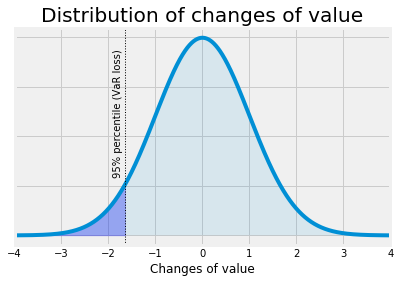

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

mu=0
sigma = 1
x = np.arange(-10, -1.645, 0.001)
x_all = np.arange(-4, 4, 0.001)
y = norm.pdf(x, 0, 1)
y2 = norm.pdf(x_all, 0, 1)

fig, ax = plt.subplots()
plt.style.use('fivethirtyeight')
ax.plot(x_all, y2)

ax.fill_between(x, y, 0, alpha=0.3, color='b')
ax.fill_between(x_all, y2, 0, alpha=0.1)
ax.set_xlim([-4, 4])
ax.set_xlabel("Changes of value")
ax.set_yticklabels([])
ax.set_title("Distribution of changes of value")
plt.axvline(x=-1.645, ymin=0, ymax=90,linestyle=':',linewidth=1, color = 'k')
plt.text(-1.9, .12, '95% percentile (VaR loss)',fontsize=10, rotation=90, color='k')

plt.savefig('normal_curve.png', dpi=72, bbox_inches='tight')
plt.show()

VaR is useful to summarize all the information about the risk of a portfolio in one single number, although this is its main limitation.

Concerning the time horizon parameter it is usually set to $N=1$ since it is not easy to estimate market variables over periods longer than 1 day. To generalize the VaR estimate it is assumed:

$$\textrm{N-day VaR} = \textrm{1-day VaR}\times \sqrt{N}$$

This relation is ture only if the value changes of the portfolio over the considered period of time have indipendent and identical normal distributions with mean 0 (otherwise it is just an approximation).

## How to Estimate the VaR

### Historical Simulation
In order to estimate the VaR from an historical series, we need to collect the market variables affecting the portfolio over the last $N$ days (with $N$ quite large). 

The variation over each day in our time interval will provide different scenarios to be applied to today's market simulation so that for each of them we need to compute the variation in the portfolio value ($\Delta P$). Our VaR estimate will be the (100 - X)% percentile of the resulting distribution.
Given the 1-day VaR it is then possible to determine the N-day VaR using the above formula.

Of course such historical simulation relies on the assumption that past behaviors are indicative of what might happen in the future.

### Model Approach
Imagine that a portfolio $P$ consists of different amounts $a_i$ invested on various assets. If with $\Delta x_i$ we denote the daily return of the ith asset the change in the value of the portfolio can be expressed as:

$$\Delta P = \sum_{i=1}^n a_i \Delta x_i$$

If we then assume that the asset variations are normally distributed with mean 0 (in this approach is typical to assume the expected change in a market variable ove the considered period zero), $\Delta P$ will be normally distributed (as a sum of normal distribution) with zero mean.

To estimate the VaR we just need to compute the standard deviation of $\Delta P$. In the general case with many different assets we define $\sigma_i$ the daily volatility of the ith asset and with $\rho_{ij}$ the correlation coefficient between the assets i and j. The variance of $\Delta P$ can then be expressed as:

$$\begin{align*}\sigma^2_P & = \sum_{i=1}^{n}\sum_{j=1}^{n}\rho_{ij}a_i a_j \sigma_i \sigma_j \\
& = \sum_{i=1}^{n} a_i^2 \sigma_i^2 + 2 \sum_{i=1}^{n}\sum_{j<i}^{n}\rho_{ij}a_i a_j \sigma_i \sigma_j \end{align*}$$

As in the previous case if we are interested in a longer time horizon we can use the previous relationship between 1-day VaR and N-day VaR.

#### Transformation to Standard Normal
Values of the Standard Normal Gaussian ($Z = \mathcal{N}(0,1)$) percentiles are tabeled everywhere and from them it is possible to derive the values relative to any other gaussian distributions.

Given a generic gaussian $\mathcal{N}(\mu , \sigma), we can get the standard gaussian as:

$$Z= \frac{X-\mu}{\sigma}$$

Assume you need to know the 1% percentile of a generic gaussian $\mathcal{N}(\mu=20 ,\sigma=5)$:

$$ Z=



### Monte Carlo Simulation
A very useful alternative to the previous approaches is using a Monte Carlo simulation to generate the probability distribution for the $\Delta P$ distribution. Imagine we need to compute the 1-day VaR for a portfolio, the following steps need to be implemented:

* determine today's value of the portfolio;
* simulate the evolution of all the portfolio market variables in one day;
* recompute the value of the portfolio using the simulated market variables;
* compute the $\Delta P$ value as the simulated minus today's value of the portfolio;
* repeat from the second step on as many times as needed to build the probability distribution for $\Delta P$.

VaR is finally estimated as the appropriate percentile of the probability distribution of $\Delta P$. As an example
suppose you have to estimate the 10-day 99% VaR and that you have computed with the procedure otulined above 1000 samples of the $\Delta P$ distribution. The 1-day 99% VaR value is the 10th worst outcome, then the 10-day VaR can be obtained as 1-day VaR $\times\sqrt{10}$.

### Stress Testing and Back Testing
In addition to calculating VaR, it can be useful to perform a *stress test*. This essentially implies to estimate how a portfolio would behave under the most extreme market moves seen in the last 20 years.
To test those effects from the historical series are taken the market variables seen in a particular day with exceptional large variations. The idea is to take into account extreme events that can occur but that have such low probability that are hard to simulate (e.g. a 5-standard deviation move should happen once every 7000 years but in practice can be observed twice over 10 years.

Another important check to be done is the so-called *back testing* which consists of checking how well the VaR estimate would have performed in the past. Basically it has to be tested how often the daily loss exceeded the N-days X% VaR just computed. If it happens on about (100-X)% of the times we can be confident that our estimate is correct.


## Exercises

### Exercise 9.1
Given the historical series of two stock prices in the file $\href{https://repl.it/@MatteoSani/support9}{\textrm{historical_data.py}}$ compute the 5-day 95% VaR for a portfolio consisting of 100 shares of stock 1 and 50 shares of stock 2 (assume that last price of the series is today's price).

### Exercise 9.2
Imagine a position consisting of 500000 EUR investemnt in FCA shares and a 750000 investiment in Apple shares. Assume that the daily volatilites of the two assets are 2.5% and 0.7% and that their correlation coefficient is 0.4.

What is tha 10-day 97.5% VaR for the portfolio ? 